<a href="https://colab.research.google.com/github/kwanhong66/KaggleShoveling/blob/master/Titanic_Top_4_with_ensemble_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle kernal transcription study #2
### Titanic Top 4% with ensemble modeling

- Kernal 주소
  * https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
- Competition 주소
  * https://www.kaggle.com/c/titanic

## Dataset with Kaggle API

In [0]:
!pip3 install -q kaggle

In [7]:
!wget 'https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json'

--2020-02-05 00:35:32--  https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘kaggle.json.1’

kaggle.json.1       100%[===================>]      63  --.-KB/s    in 0s      

2020-02-05 00:35:32 (22.1 MB/s) - ‘kaggle.json.1’ saved [63/63]



In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions list

ref                                            deadline             category             reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started   Knowledge       2354           False  
titanic                                        2030-01-01 00:00:00  Getting Started   Knowledge      15796            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started   Knowledge       4986            True  
connectx                                       2030-01-01 00:00:00  Getting Started   Knowledge        394           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research          Knowledge         64           False  
competitive-data-science-predict-future-sales  2020-12-31 23:59:00  Playground            Kudos       5627           False  


In [11]:
!kaggle competitions download 'titanic'

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 22.5MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.23MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 28.6MB/s]


In [0]:
!mkdir input

In [0]:
!cp /content/train.csv /content/test.csv /content/gender_submission.csv /content/input

## Titanic Top 4% with ensemble modeling

- **1 Introduction**
- **2 Load and check data**
  * 2.1 load data
  * 2.2 Outlier detection
  * 2.3 joining train and test set
  * 2.4 check for null and missing values
- **3 Feature analysis**
  * 3.1 Numerical values
  * 3.2 Categorical values
- **4 Filling missing Values**
  * 4.1 Age
- **5 Feature engineering**
  * 5.1 Name/Title
  * 5.2 Family Size
  * 5.3 Cabin
  * 5.4 Ticket
- **6 Modeling**
  * 6.1 Simple modeling
  * 6.1.1 Cross validate models
    * 6.1.2 Hyperparamater tunning for best models
    * 6.1.3 Plot learning curves
    * 6.1.4 Feature importance of the tree based classifiers
  * 6.2 Ensemble modeling
    * 6.2.1 Combining models
  * 6.3 Prediction
    * 6.3.1 Predict and Submit results

## 1. Introduction

This script follows three main parts:

 - Feature analysis
 - Feature engineering
 - Modeling

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load data

In [0]:
# Load data
##### Load train and Test set
train = pd.read_csv('/content/input/train.csv')
test = pd.read_csv('/content/input/test.csv')
IDtest = test['PassengerId']

### 2.2 Outlier detection

In [0]:
# Outlier detection

def detect_outliers(df, n, features):
  """
  Takes a dataframe df of features and return a list of the indices
  corresponding to the observations containing more than n outliers according
  to the Tukey method.
  """
  outlier_indices = []

  # iterate over features(columns)
  for col in features:
    # 1st quartile (25%)
    Q1 = np.percentile(df[col], 25)
    # 3rd quartile (75%)
    Q3 = np.percentile(df[col], 75)
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.5 * IQR

    # Determine a list of indices of outliers for feature col
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    # append the found outlier indices for col to the list of outlier indices
    outlier_indices.extend(outlier_list_col)

  # select observations containing more than 2 outliers
  outlier_indices = Counter(outlier_indices)   
  multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

  return multiple_outliers

# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [17]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [0]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

### 2.3 joining train and test set

In [19]:
## Join train and test datsets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### 2.4 check for null and missing values

In [20]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [21]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [24]:
### Summarize data
# Summary and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values

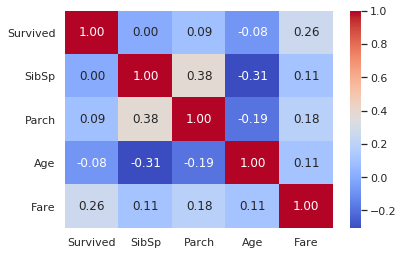

In [25]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt=".2f", cmap='coolwarm')

#### SibSp

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3678: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


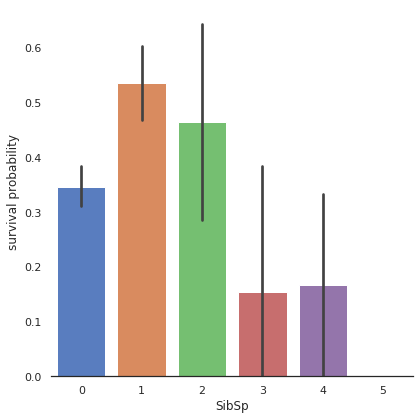

In [26]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

#### Parch

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3678: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


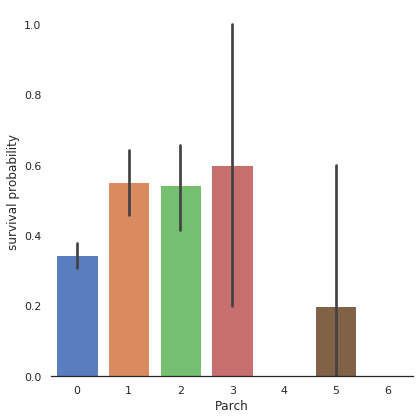

In [27]:
# Explore Parch feature vs Survived
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

#### Age

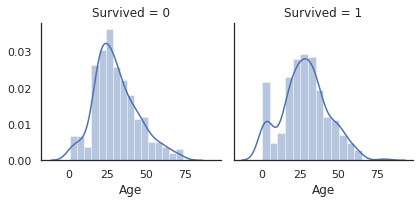

In [28]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

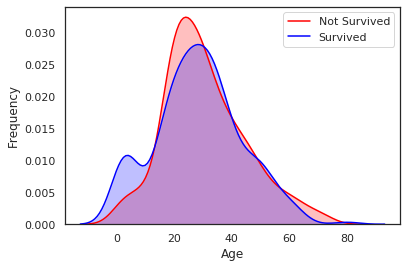

In [29]:
# Explore Age distribution
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color='blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

#### Fare

In [30]:
dataset['Fare'].isnull().sum()

1

In [0]:
# Fill Fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

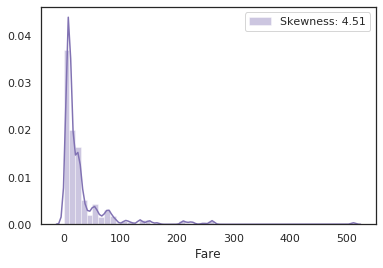

In [32]:
# Explore Fare distribution
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()) )
g = g.legend(loc='best')

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

In [0]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

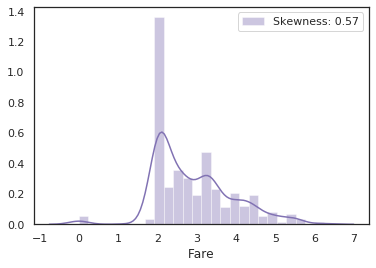

In [34]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()) )
g = g.legend(loc='best')

Skewness is clearly reduced after the log transformation

### 3.2 Categorical values

#### Sex

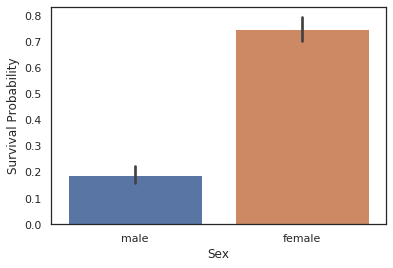

In [35]:
g = sns.barplot('Sex', 'Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [36]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


#### Pclass

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3678: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


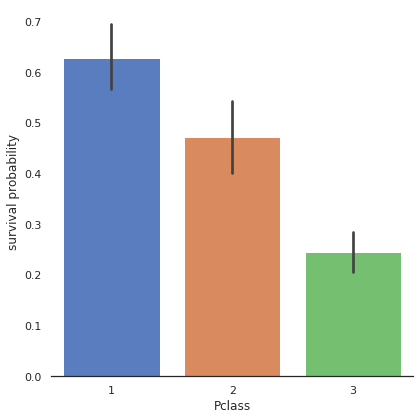

In [37]:
# Explore Pclass vs Survived
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3678: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


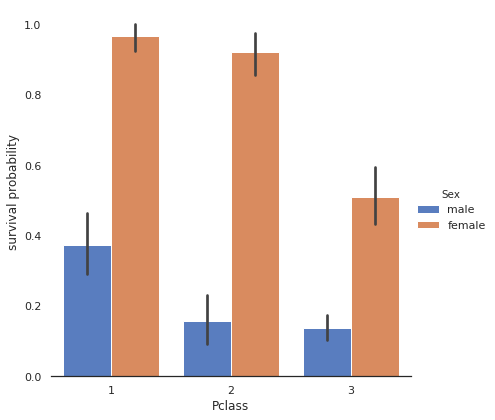

In [38]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='bar', 
                   size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

#### Embarked

In [39]:
dataset['Embarked'].isnull().sum()

2

In [0]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3678: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


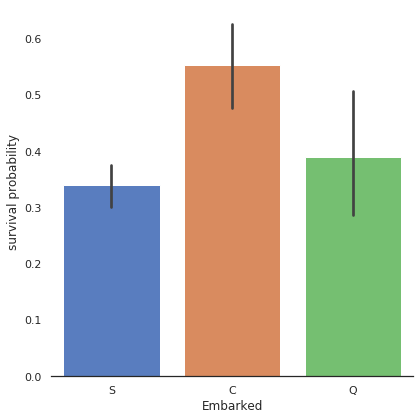

In [41]:
# Explore Embarked vs Survived
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

It seems that passenger coming from Cherbourg (C) have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).

Let's see the Pclass distribution vs Embarked

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3678: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


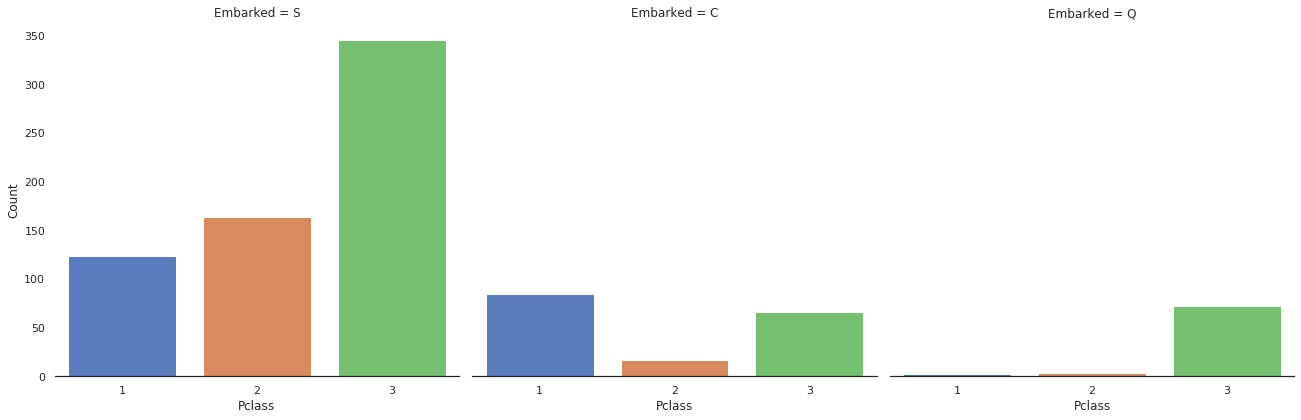

In [42]:
# Explore Pclass vs Embarked
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

## 4. Filling missing values

### 4.1 Age

As we see, Age column contains 256 missing values in the whole dataset.

Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

To adress this problem, i looked at the most correlated features with Age (Sex, Parch , Pclass and SibSP).

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

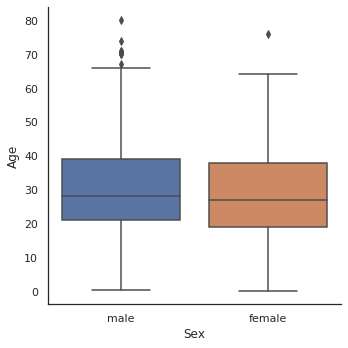

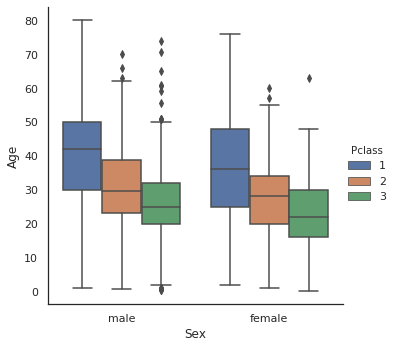

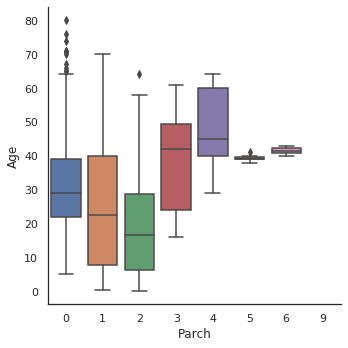

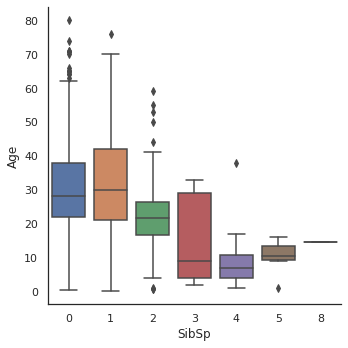

In [43]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

In [0]:
# convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({"male": 0, "female": 1})

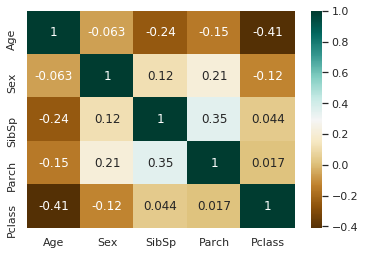

In [45]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), annot=True, cmap='BrBG')

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of parents / children. But the general correlation is negative.

So, i decided to use SibSP, Parch and Pclass in order to impute the missing ages.

The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

In [46]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & 
                             (dataset['Parch'] == dataset.iloc[i]['Parch']) &
                             (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
  if not np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_pred
  else:
    dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


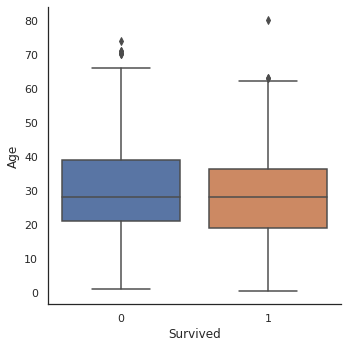

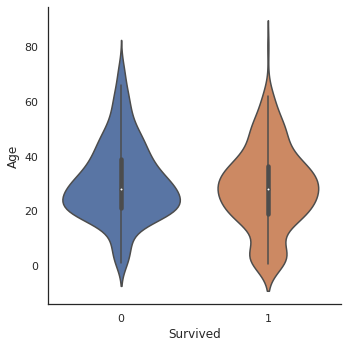

In [47]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

## 5. Feature engineering

### 5.1 Name/Title

In [48]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [49]:
# Get Title from Name
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

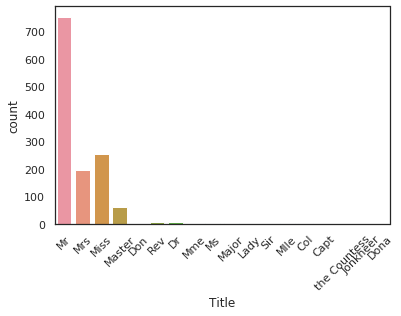

In [50]:
g = sns.countplot('Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [0]:
# Convert to categorical values Title
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Capt', 'Col',
                                             'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                             'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1,
                                         "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3})
dataset['Title'] = dataset['Title'].astype(int)

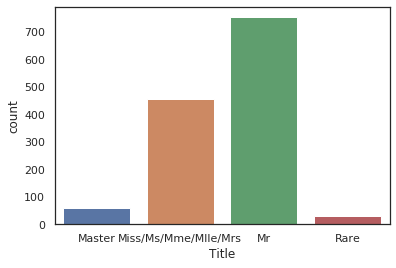

In [52]:
g = sns.countplot("Title", data=dataset)
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


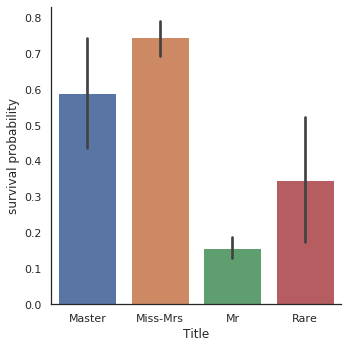

In [53]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

In [0]:
# Drop name variables
dataset.drop(labels=['Name'], axis=1, inplace=True)

### 5.2 Family size

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, i choosed to create a "Fize" (family size) feature which is the sum of SibSp , Parch and 1 (including the passenger).

In [0]:
# Create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


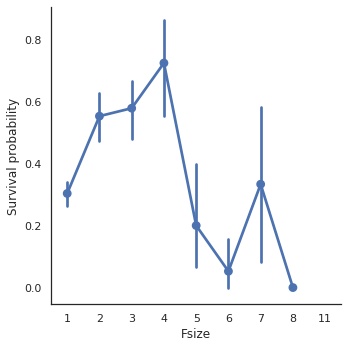

In [56]:
g = sns.factorplot('Fsize', 'Survived', data=dataset)
g = g.set_ylabels('Survival probability')

The family size seems to play an important role, survival probability is worst for large families.

Additionally, i decided to created 4 categories of family size.

In [0]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


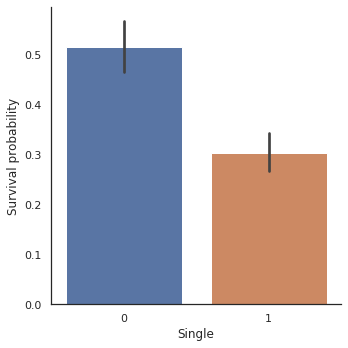

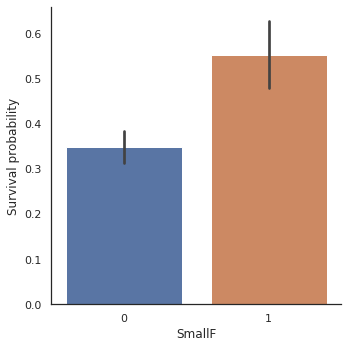

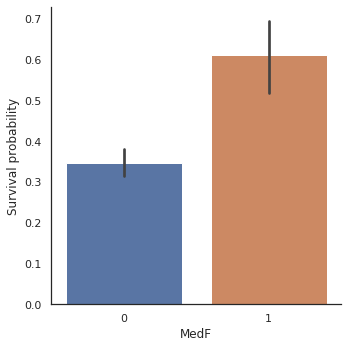

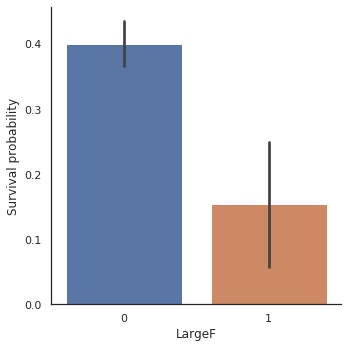

In [58]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')
g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')
g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')
g = sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [0]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [60]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,2,0,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,2,0,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1,1,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,2,0,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,1,1,0,0,0,0,0,1,0,0,0,1


### 5.3 Cabin

In [61]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [62]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [63]:
dataset['Cabin'].isnull().sum()

1007

The Cabin feature column contains 292 values and 1007 missing values.

I supposed that passengers without a cabin have a missing value displayed instead of the cabin number.

In [64]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [0]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

The first letter of the cabin indicates the Desk, i choosed to keep this information only, since it indicates the probable location of the passenger in the Titanic.

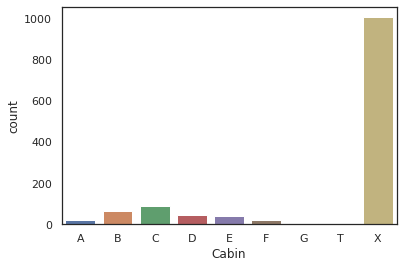

In [66]:
g = sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


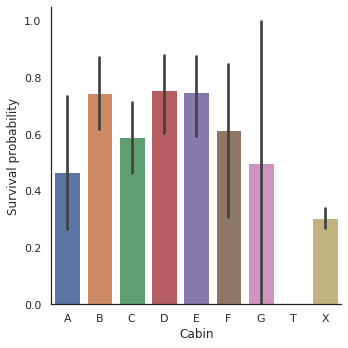

In [67]:
g = sns.factorplot(y='Survived', x='Cabin', data=dataset, kind='bar', 
                   order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival probability')

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B, C, D, E and F.

In [0]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

### 5.4 Ticket

In [69]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

Tickets with same prefixes may have a similar class and survival.

So i decided to replace the Ticket feature column by the ticket prefixe. Which may be more informative.

In [70]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0])
  else:
    Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [0]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [0]:
# Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [0]:
# Drop useless variables
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [74]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## 6. Modeling

In [75]:
## Separate train dataset and test dataset
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [76]:
## Separate train features and label
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 6.1 Simple modeling

#### 6.1.1 Cross validate models
I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [0]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

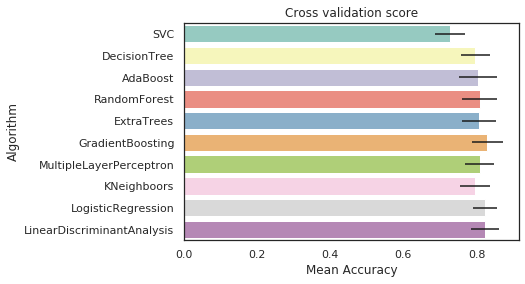

In [78]:
# Modeling step Test different algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy',
                                    cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means,
                       'CrossValerrors': cv_std,
                       'Algorithm': ["SVC","DecisionTree","AdaBoost",
                                     "RandomForest","ExtraTrees","GradientBoosting",
                                     "MultipleLayerPerceptron","KNeighboors","LogisticRegression",
                                     "LinearDiscriminantAnalysis"]})  
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3',
                orient='h', **{'xerr': cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation score')

#### 6.1.2 Hyperparameter tunning for best models

I performed a grid search optimization for AdaBoost, ExtraTrees , RandomForest, GradientBoosting and SVC classifiers.

I set the "n_jobs" parameter to 4 since i have 4 cpu . The computation time is clearly reduced.

But be carefull, this step can take a long time, i took me 15 min in total on 4 cpu.

In [79]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" :[1,2],
                  "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy',
                        n_jobs=4, verbose=1)

gsadaDTC.fit(X_train, Y_train)                  

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   11.4s finished


In [80]:
gsadaDTC.best_score_

0.8241445352400408

In [81]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {'max_depth': [None],
                 'max_features': [1, 3, 10],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [False],
                 'n_estimators': [100, 300],
                 'criterion': ['gini']}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, 
                      scoring='accuracy', n_jobs=4, verbose=1)
gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.0min finished


0.8297369765066394

In [82]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators" :[100,300],
                 "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, 
                     scoring='accuracy', n_jobs=4, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   40.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.1min finished


0.8342951991828397

In [83]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss': ['deviance'],
                 'n_estimators': [100, 200, 300],
                 'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 0],
                 'min_samples_leaf': [100, 150],
                 'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy',
                     n_jobs=4, verbose=1)                 
gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 362 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   41.8s finished


0.8297497446373852

In [84]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy',
                      n_jobs=4, verbose=1)
gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.2min finished


0.8331332992849847

#### 6.1.3 Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

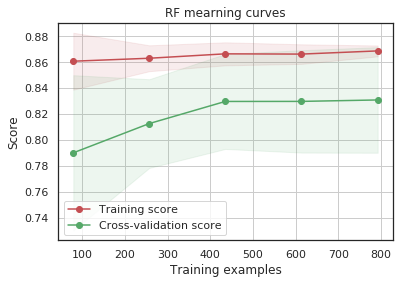

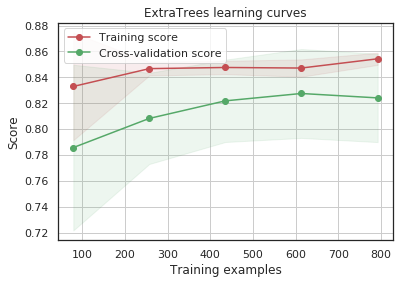

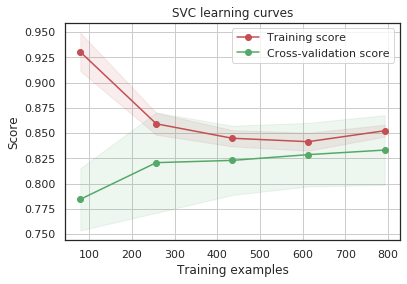

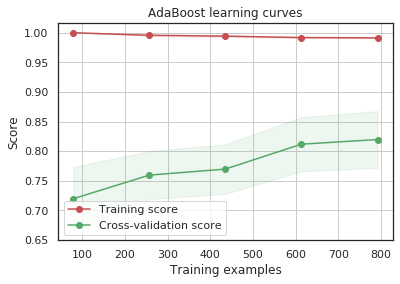

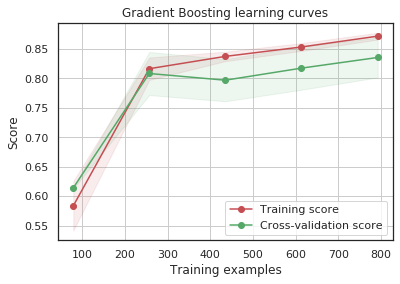

In [85]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
  """Generate a simple plot of the test and training learning curve"""
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel('Training examples')
  plt.ylabel('Score')
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                   train_scores_mean + train_scores_std, alpha=0.1, color='r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                   test_scores_mean + test_scores_std, alpha=0.1, color='g')
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
           label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
           label='Cross-validation score')  
  plt.legend(loc='best')
  return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RF mearning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'Gradient Boosting learning curves', X_train, Y_train, cv=kfold)

GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

#### 6.1.4 Feature importance of tree based classifiers

In order to see the most informative features for the prediction of passengers survival, i displayed the feature importance for the 4 tree based classifiers.

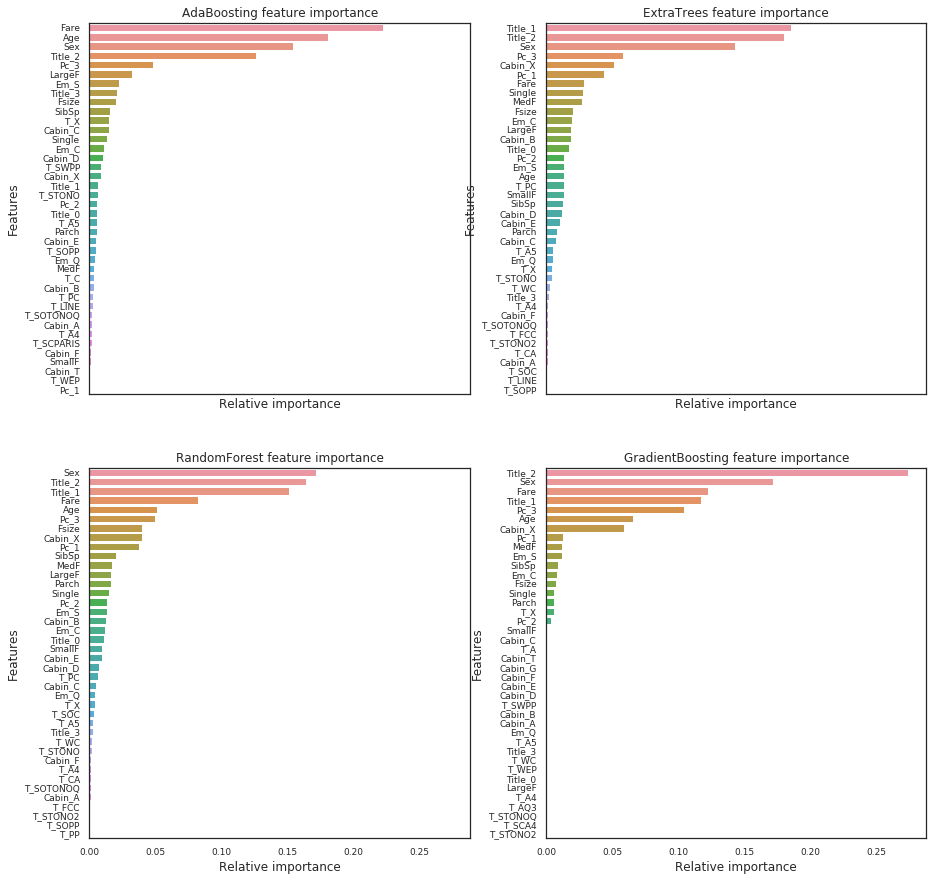

In [88]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15,15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), 
                     ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]

nclassifier = 0
for row in range(nrows):
  for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40], 
                    x = classifier.feature_importances_[indices][:40] , 
                    orient='h',ax=axes[row][col])
    g.set_xlabel('Relative importance', fontsize=12)
    g.set_ylabel('Features', fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + ' feature importance')
    nclassifier += 1

I plot the feature importance for the 4 tree based classifiers (Adaboost, ExtraTrees, RandomForest and GradientBoosting).

We note that the four classifiers have different top features according to the relative importance. It means that their predictions are not based on the same features. Nevertheless, they share some common important features for the classification , for example 'Fare', 'Title_2', 'Age' and 'Sex'.

Title_2 which indicates the Mrs/Mlle/Mme/Miss/Ms category is highly correlated with Sex.

We can say that:

Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.

Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3 (Mr) refer to the gender.

Age and Title_1 (Master) refer to the age of passengers.

Fsize, LargeF, MedF, Single refer to the size of the passenger family.

**According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, the Sex, the family size and the social standing of the passengers more than the location in the boat.**

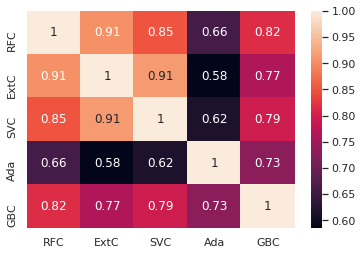

In [89]:
test_survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_survived_AdaC = pd.Series(ada_best.predict(test), name='Ada')
test_survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

# Concatenate all classifier results
ensemble_results = pd.concat([test_survived_RFC, test_survived_ExtC, 
                              test_survived_SVMC, test_survived_AdaC,
                              test_survived_GBC], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

The prediction seems to be quite similar for the 5 classifiers except when Adaboost is compared to the others classifiers.

The 5 classifiers give more or less the same prediction but there is some differences. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote.

### 6.2 Ensemble modeling

#### 6.2.1 Combining models

I choosed a voting classifier to combine the predictions coming from the 5 classifiers.

I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [0]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
                                       ('svc', SVMC_best), ('adac', ada_best),
                                       ('gbc', GBC_best)], 
                           voting='soft',
                           n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction

#### 6.3.1 Predict and submit results

In [0]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('ensemble_python_voting.csv', index=False)